In [46]:
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.4.1


In [5]:
# Image size that we are going to use
IMG_SIZE = 128
# Our images are RGB (3 channels)
N_CHANNELS = 3

In [34]:
SEED = 42

dataset_path = "data/"
training_data = "training/images/"
val_data = "validation/images/"

In [35]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.png"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 1015 images.
The Validation Dataset contains 1015 images.


In [36]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, input_mask

In [37]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [38]:
@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [39]:
def parse_image(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask = tf.io.read_file(mask_path)
    
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)

    return {'image': image, 'segmentation_mask': mask}

# Train and test datasets

https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/

In [41]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.png", seed=SEED)
val_dataset =val_dataset.map(parse_image)

In [31]:
train_dataset

<MapDataset shapes: {image: (None, None, 3), segmentation_mask: (None, None, 1)}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>

In [58]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


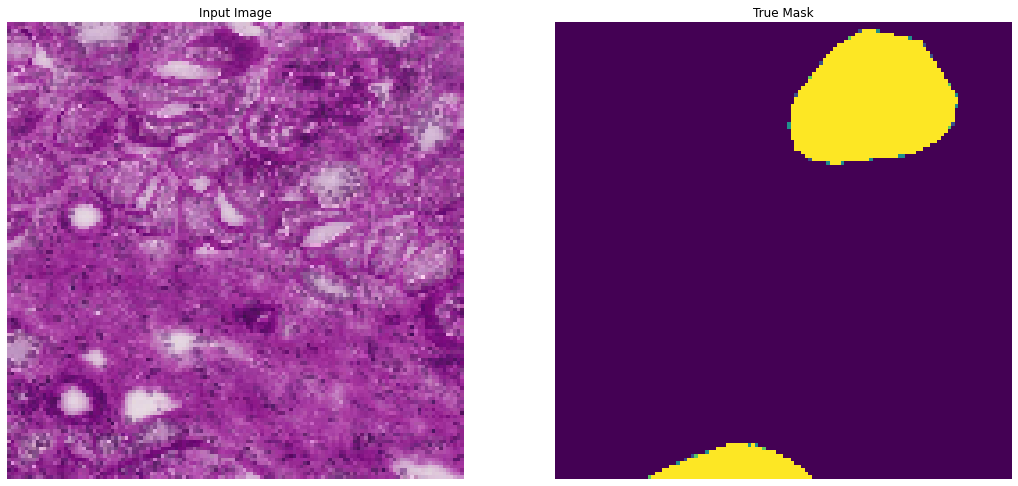

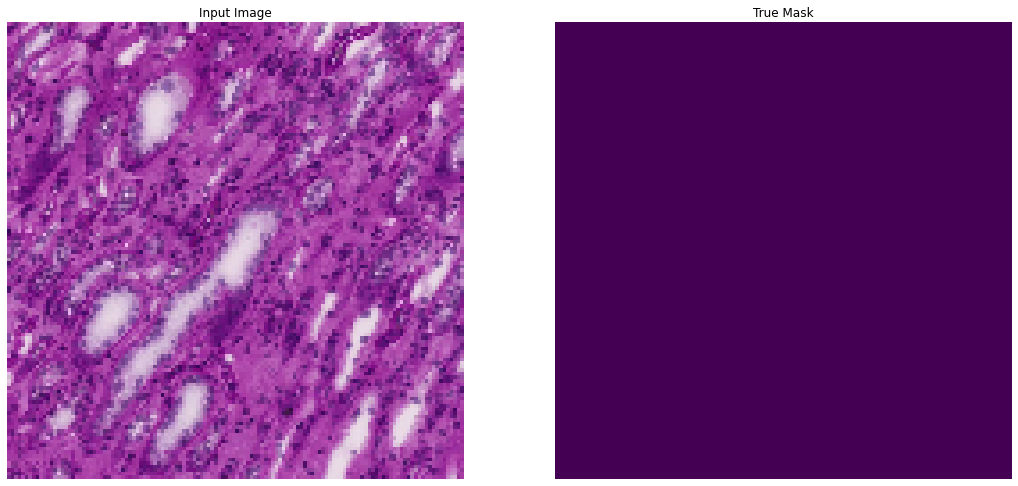

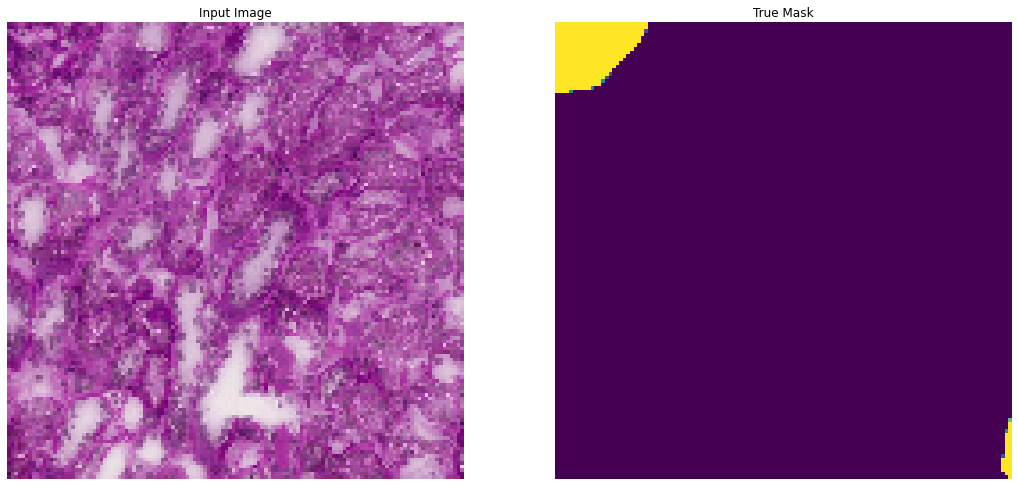

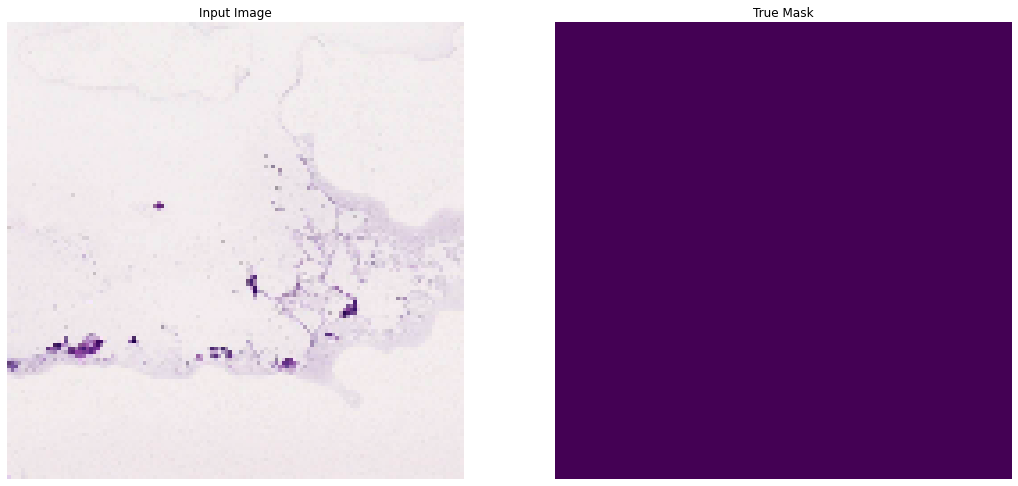

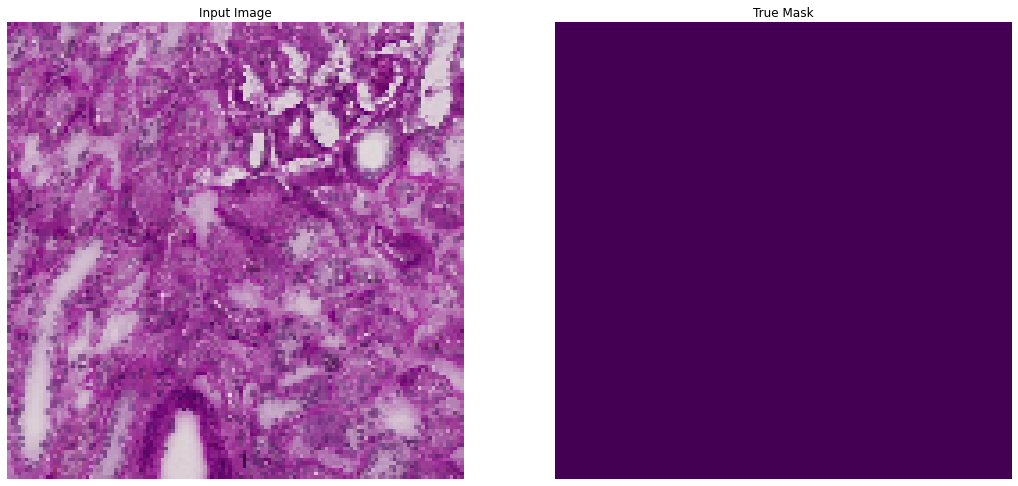

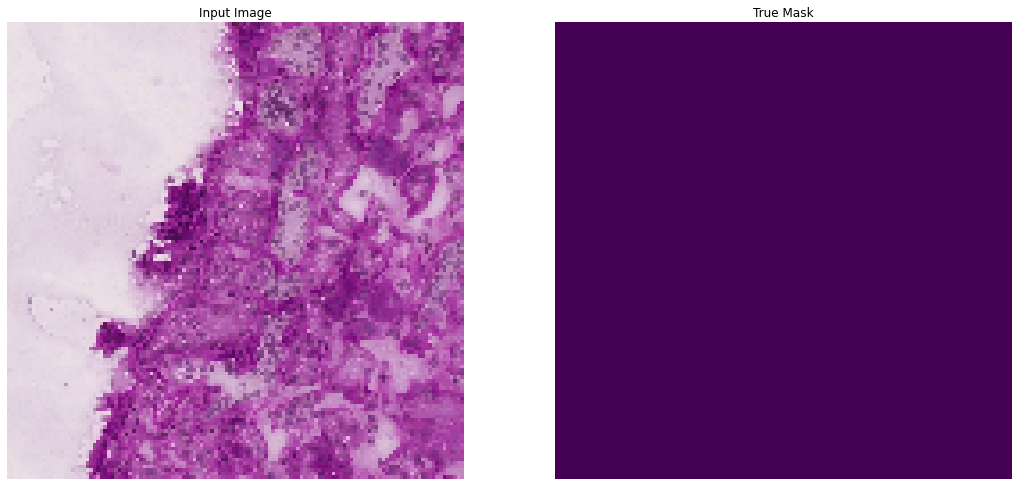

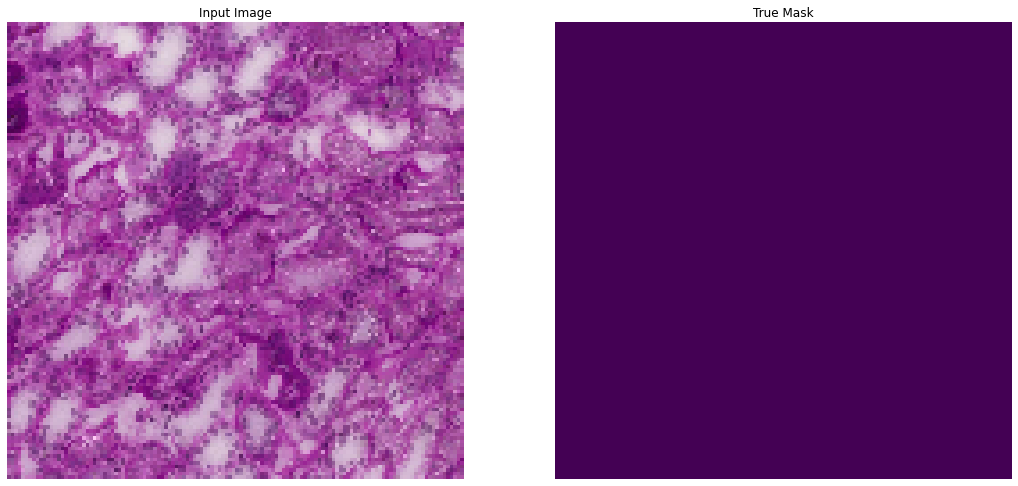

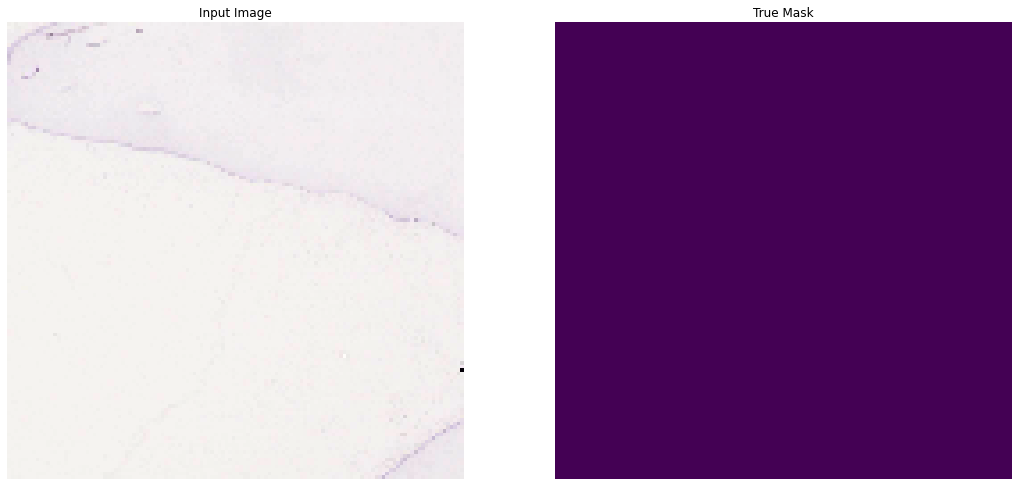

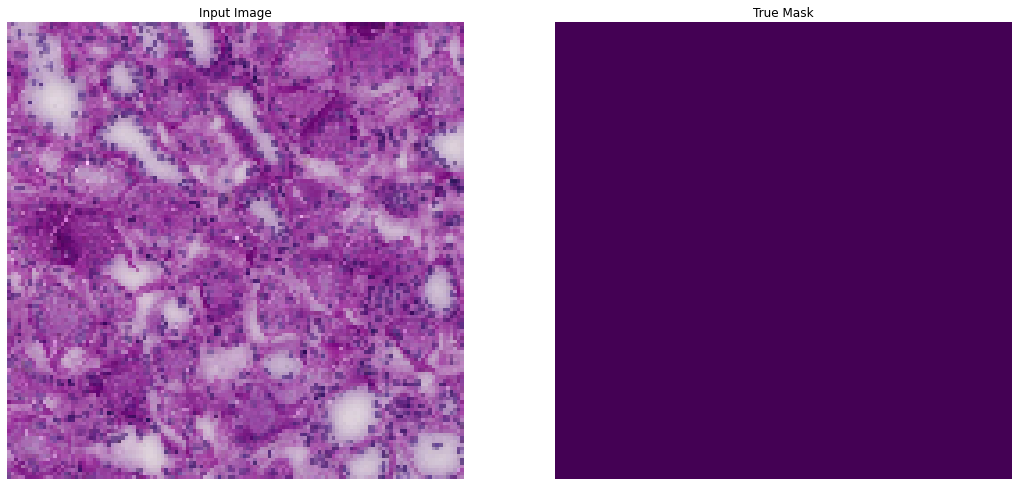

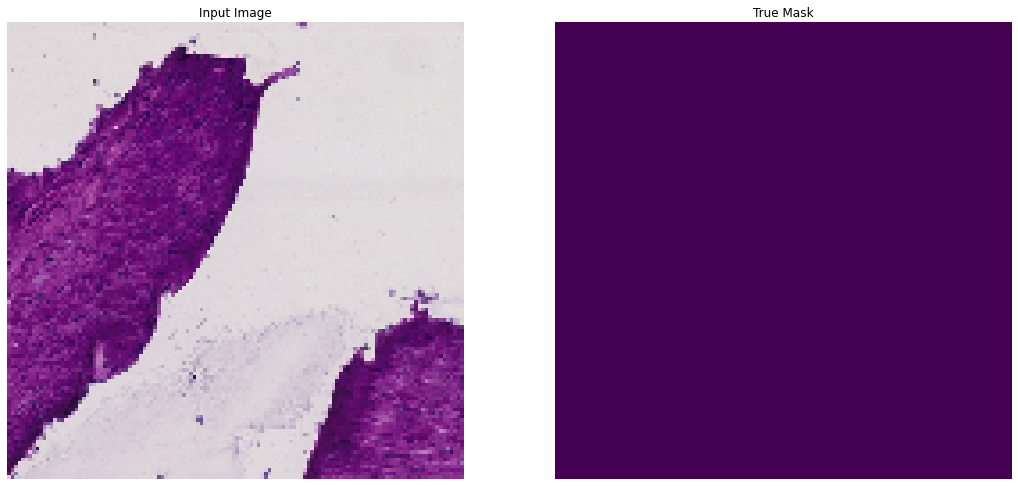

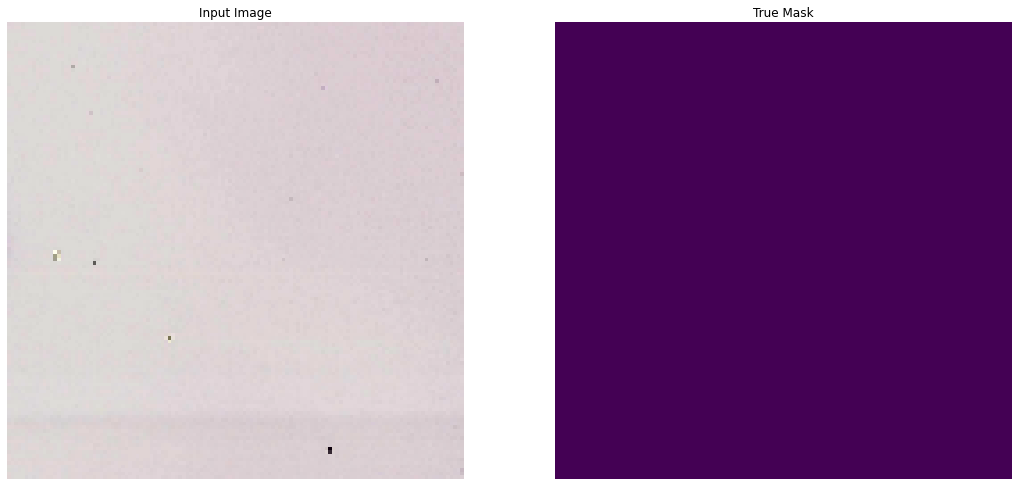

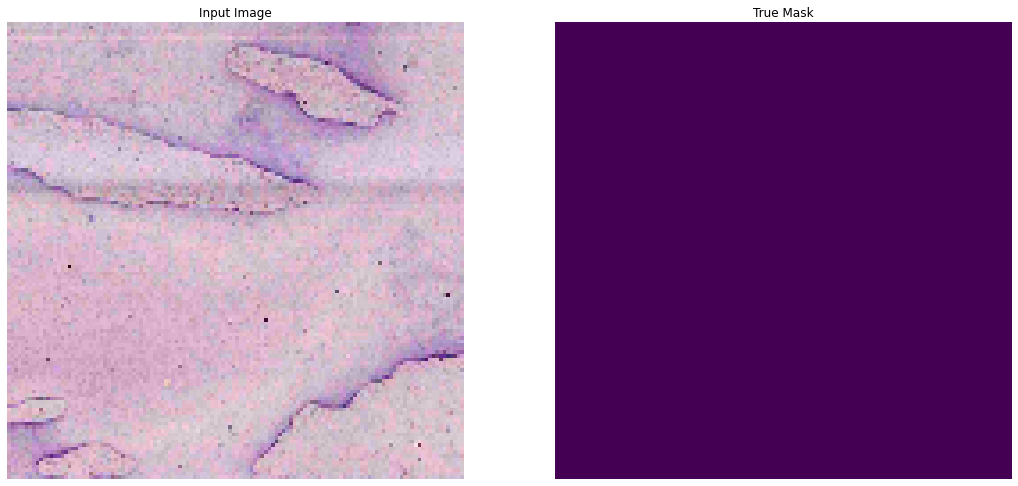

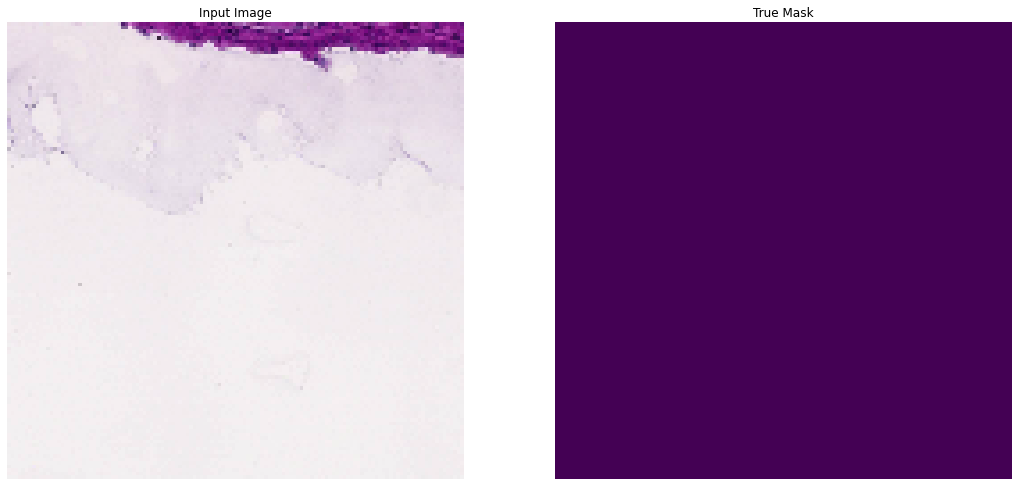

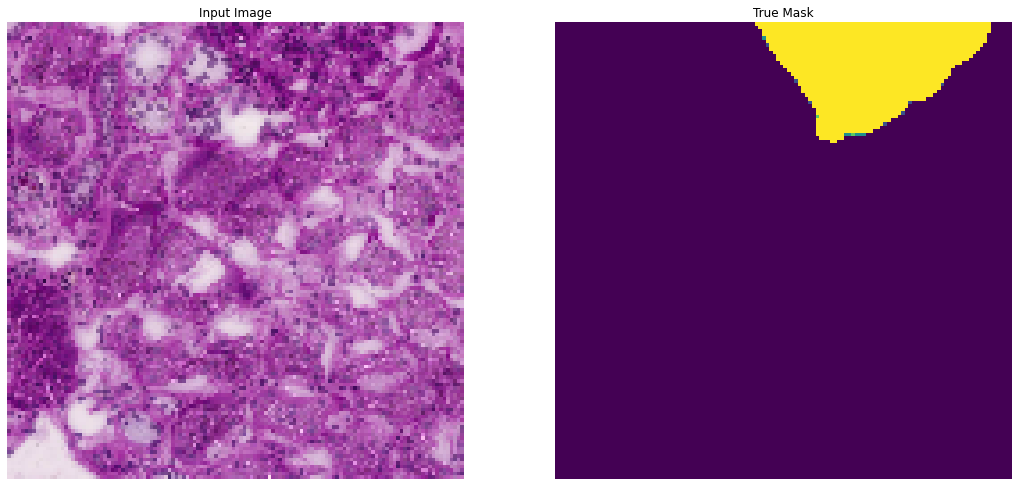

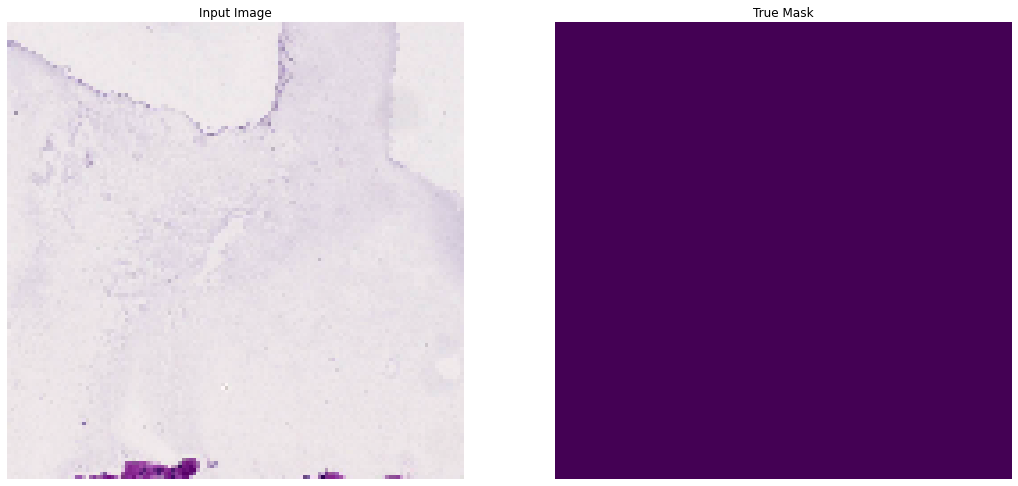

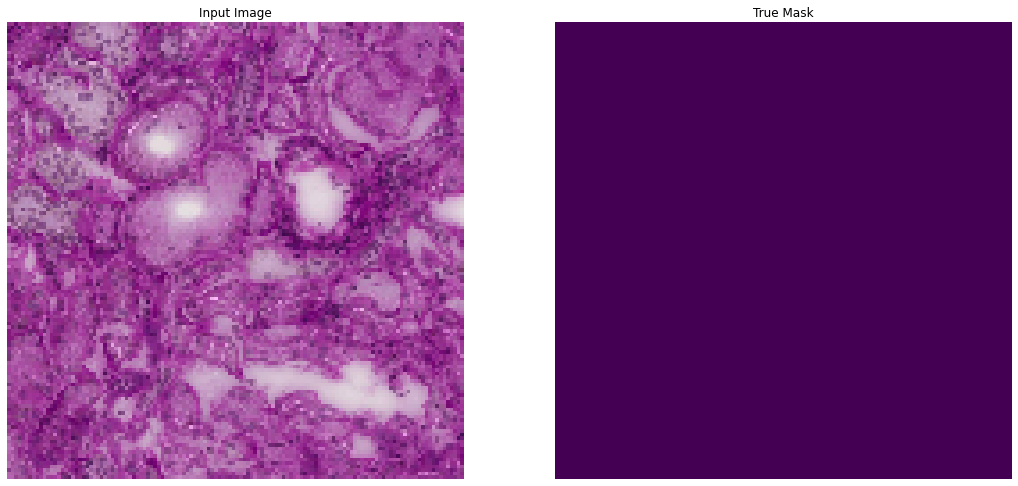

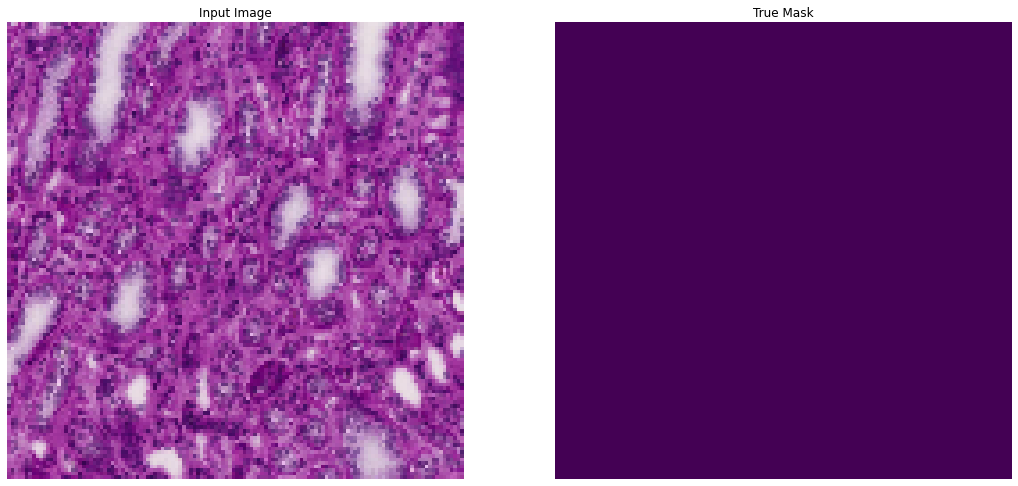

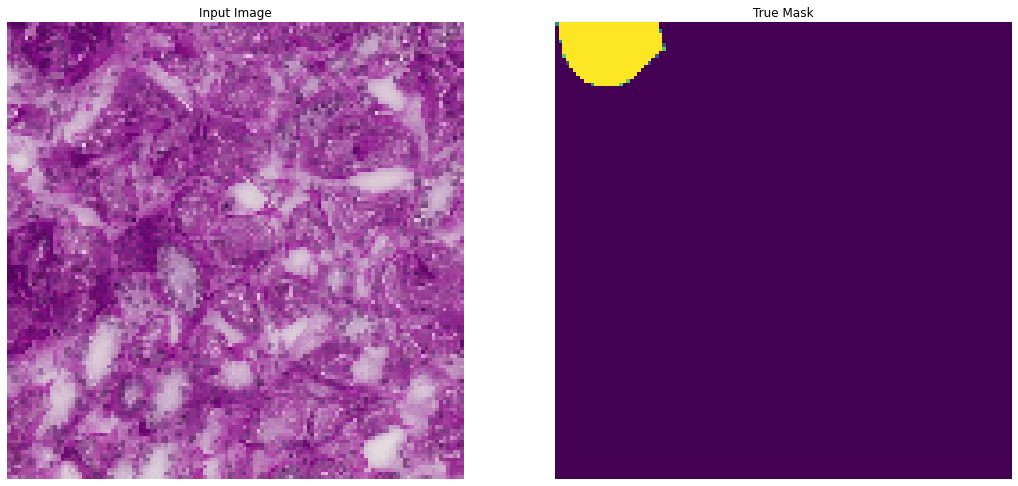

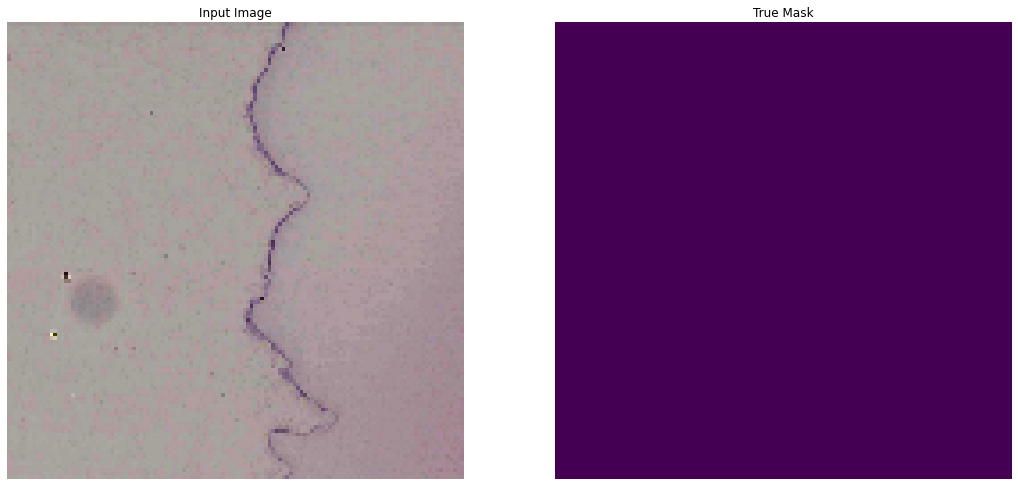

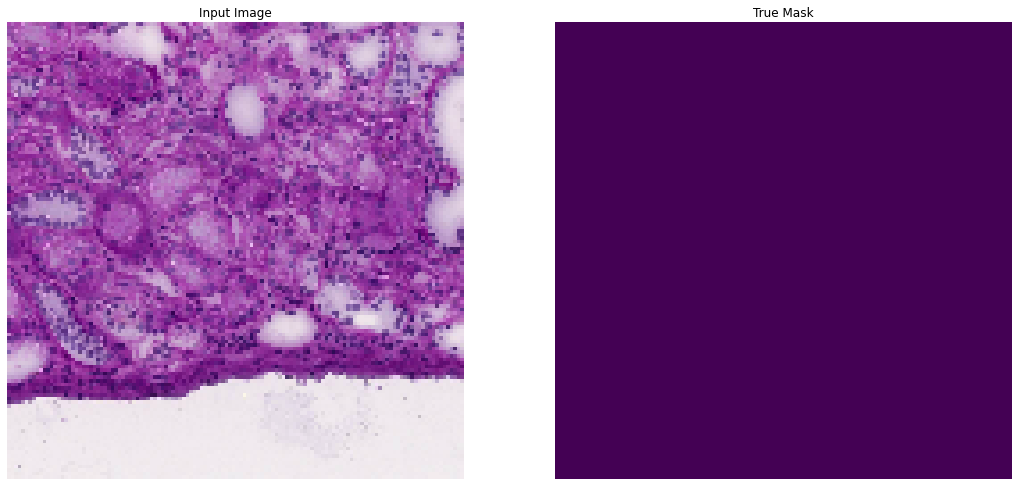

In [60]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
    
for image, mask in dataset['train'].take(20):
    sample_image, sample_mask = image, mask

    display_sample([sample_image[0], sample_mask[0]])